<a href="https://colab.research.google.com/github/shemeemnpa/Shemeem/blob/main/Shemeem_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Skin Cancer Data**

**Importing all the important libraries**

In [13]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

**Data Reading/Data Understanding**


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
!unzip '/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip' -d '/content/gdrive/MyDrive/Upgrad/Dataset/'

Archive:  /content/gdrive/MyDrive/Upgrad/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  in

In [15]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [16]:
!ls

gdrive	sample_data


**Dataset Creation→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180**

In [17]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [18]:
batch_size = 32
img_height = 180
img_width = 180

**Creation of Training dataset**

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


**Creation of validation dataset**

In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [21]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [22]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


**Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset**

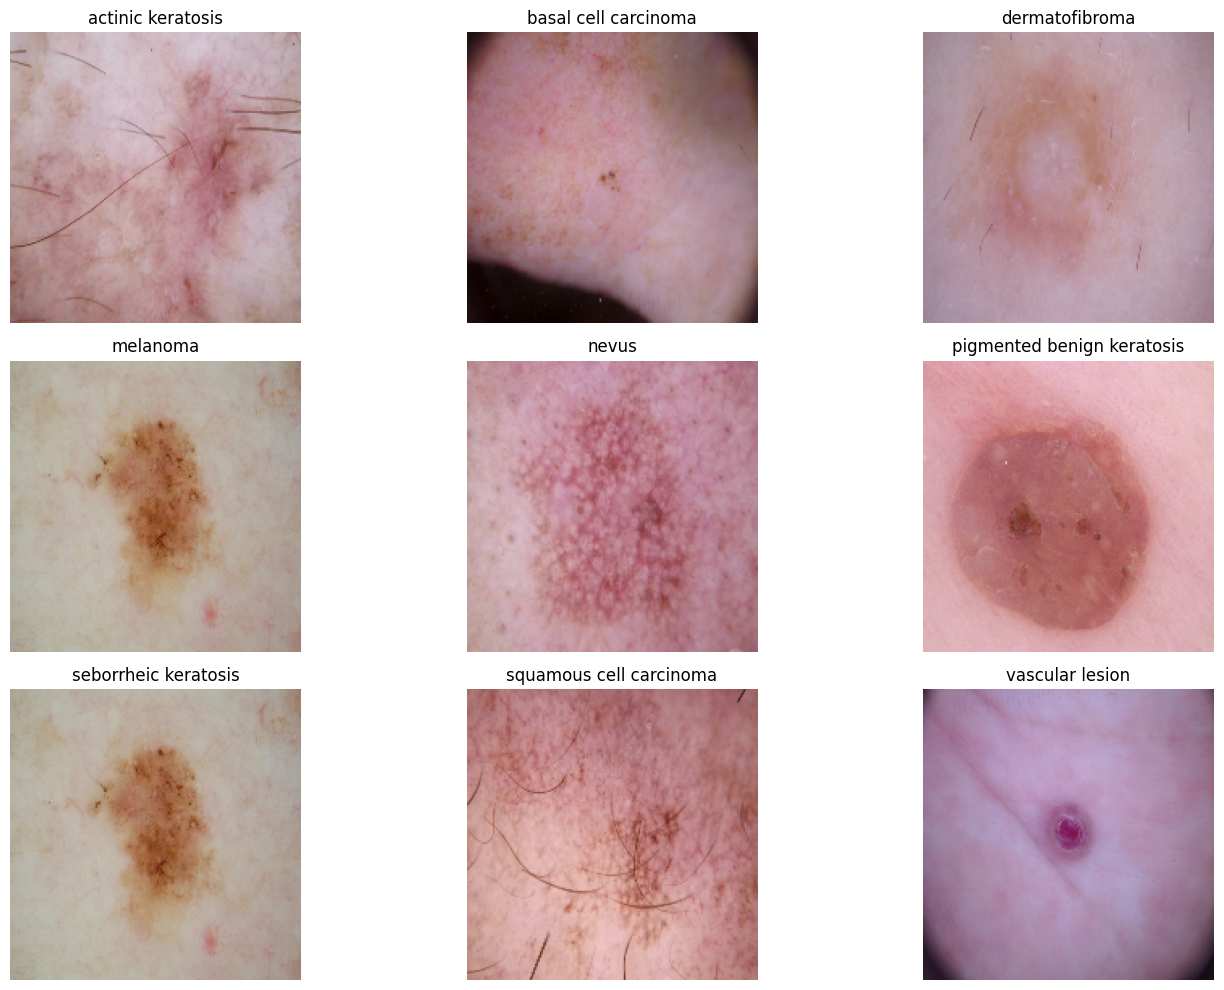

In [23]:
import matplotlib.pyplot as plt

# Create an empty dictionary to store one instance of each class
class_samples = {class_name: None for class_name in class_names}

# Iterate through the dataset to find one instance of each class
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_samples[class_name] is None:
            class_samples[class_name] = image.numpy()
            break

# Visualize one instance of each class
plt.figure(figsize=(15, 10))
for i, (class_name, image) in enumerate(class_samples.items()):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [24]:
#print(type(train_ds))
#print(len(train_ds)

In [25]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **CNN MODEL**

In [26]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


In [27]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Compile the model**

In [28]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the model for ~20 epochs

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 87s 1s/step - loss: 1.9225 - accuracy: 0.2952 - val_loss: 1.6963 - val_accuracy: 0.4362
Epoch 2/20
56/56 [==============================] - 66s 1s/step - loss: 1.6025 - accuracy: 0.4442 - val_loss: 1.5545 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 1.4222 - accuracy: 0.5073 - val_loss: 1.4775 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 66s 1s/step - loss: 1.3585 - accuracy: 0.5307 - val_loss: 1.4247 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 71s 1s/step - loss: 1.2694 - accuracy: 0.5653 - val_loss: 1.3418 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 68s 1s/step - loss: 1.2021 - accuracy: 0.5731 - val_loss: 1.4449 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 67s 1s/step - loss: 1.1111 - accuracy: 0.6105 - val_loss: 1.6655 - val_accuracy: 0.4385
Epoch 8/20
56/56 [==

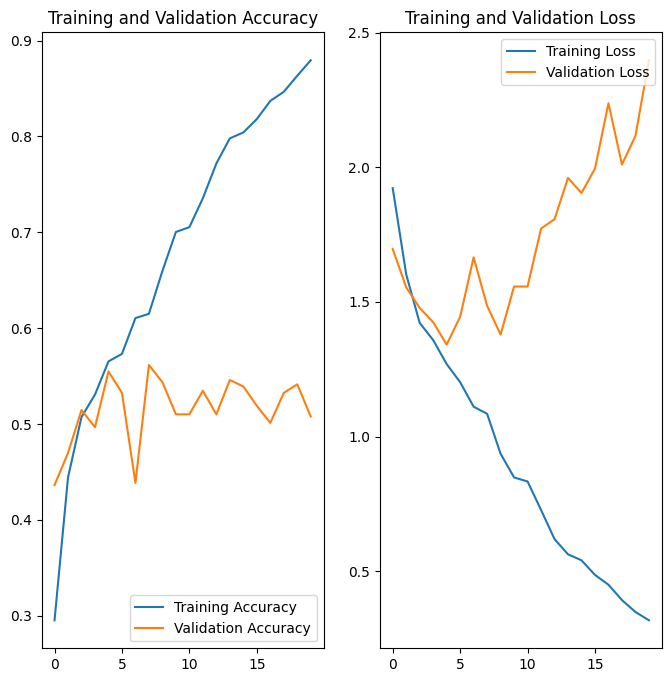

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

High Training Accuracy and low validation accuracy. The valdation loss is very high. The model seems overfitting

In [31]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

In [32]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

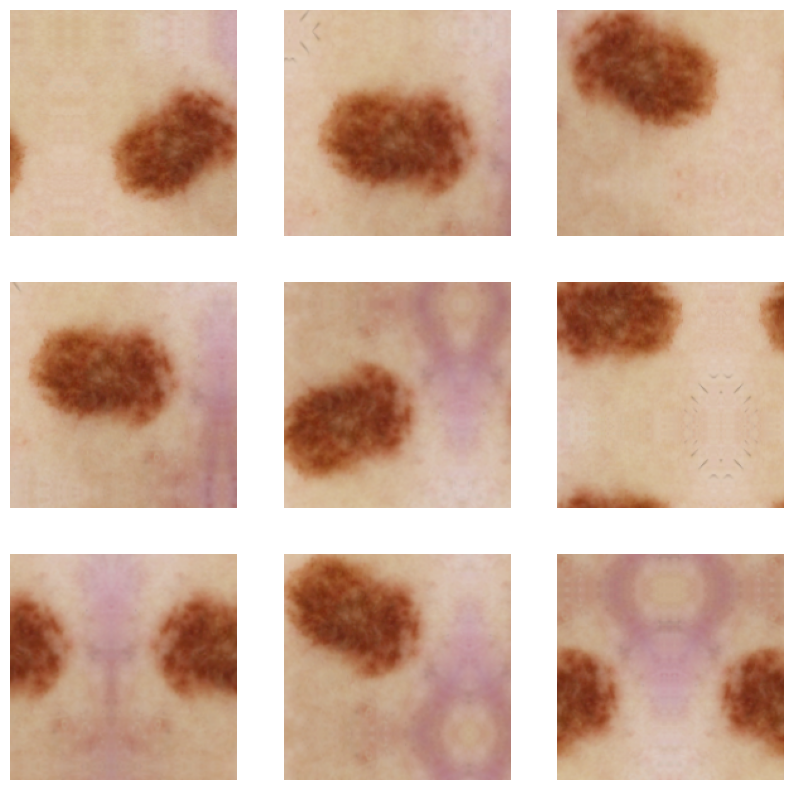

In [33]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [34]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [35]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 466s 8s/step - loss: 2.1752 - accuracy: 0.2109 - val_loss: 1.9587 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 456s 8s/step - loss: 1.8943 - accuracy: 0.3019 - val_loss: 1.7770 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 460s 8s/step - loss: 1.7287 - accuracy: 0.3482 - val_loss: 1.7122 - val_accuracy: 0.3557
Epoch 4/20
56/56 [==============================] - 458s 8s/step - loss: 1.7428 - accuracy: 0.3571 - val_loss: 1.6455 - val_accuracy: 0.4027
Epoch 5/20
56/56 [==============================] - 452s 8s/step - loss: 1.6607 - accuracy: 0.3733 - val_loss: 1.6473 - val_accuracy: 0.3893
Epoch 6/20
56/56 [==============================] - 452s 8s/step - loss: 1.5867 - accuracy: 0.4062 - val_loss: 1.6351 - val_accuracy: 0.4027
Epoch 7/20
56/56 [==============================] - 453s 8s/step - loss: 1.5698 - accuracy: 0.4213 - val_loss: 1.5971 - val_accuracy: 0.4519
Epoch 8/20
56

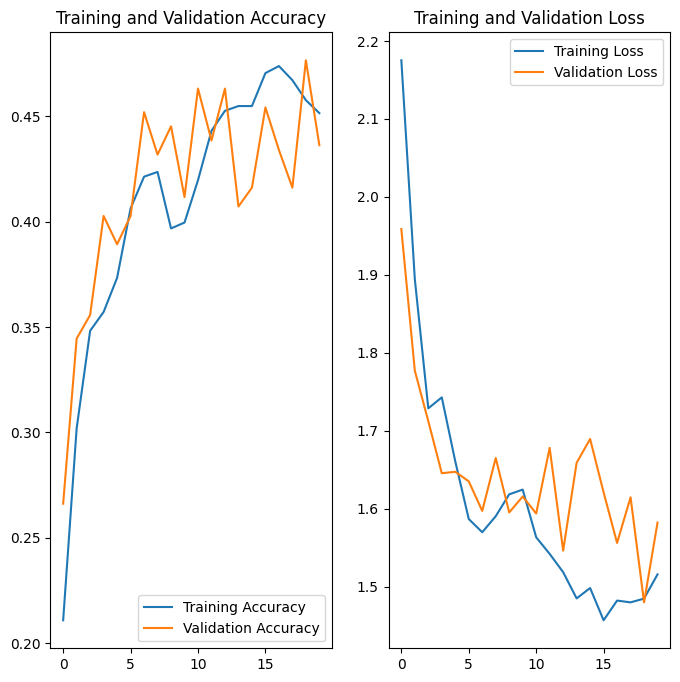

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training and validation accuracy is almost same. The Training and validation loss is almost same. The issue of Overfitting in the earlier model is attended in this model

In [38]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
val_dir = os.path.join('/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [40]:
#Create a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#https://keras.io/api/layers/regularization_layers/dropout/
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

#Just your regular densely-connected NN layer.
#Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
#It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
#Dense implements the operation: output = activation(dot(input, kernel)
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:


# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)


Epoch 1/10
23/23 [==============================] - 231s 10s/step - loss: 2.6308 - accuracy: 0.2077 - val_loss: 2.1464 - val_accuracy: 0.2288
Epoch 2/10
23/23 [==============================] - 205s 9s/step - loss: 1.7519 - accuracy: 0.3510 - val_loss: 2.3286 - val_accuracy: 0.2966
Epoch 3/10
23/23 [==============================] - 212s 9s/step - loss: 1.5579 - accuracy: 0.4529 - val_loss: 2.3984 - val_accuracy: 0.2797
Epoch 4/10
23/23 [==============================] - 206s 9s/step - loss: 1.5413 - accuracy: 0.4565 - val_loss: 2.2315 - val_accuracy: 0.2966
Epoch 5/10
23/23 [==============================] - 206s 9s/step - loss: 1.4381 - accuracy: 0.4864 - val_loss: 2.3587 - val_accuracy: 0.3475
Epoch 6/10
23/23 [==============================] - 216s 9s/step - loss: 1.4171 - accuracy: 0.4962 - val_loss: 2.3393 - val_accuracy: 0.3644
Epoch 7/10
23/23 [==============================] - 203s 9s/step - loss: 1.3803 - accuracy: 0.5217 - val_loss: 2.4700 - val_accuracy: 0.3220
Epoch 8/10
2

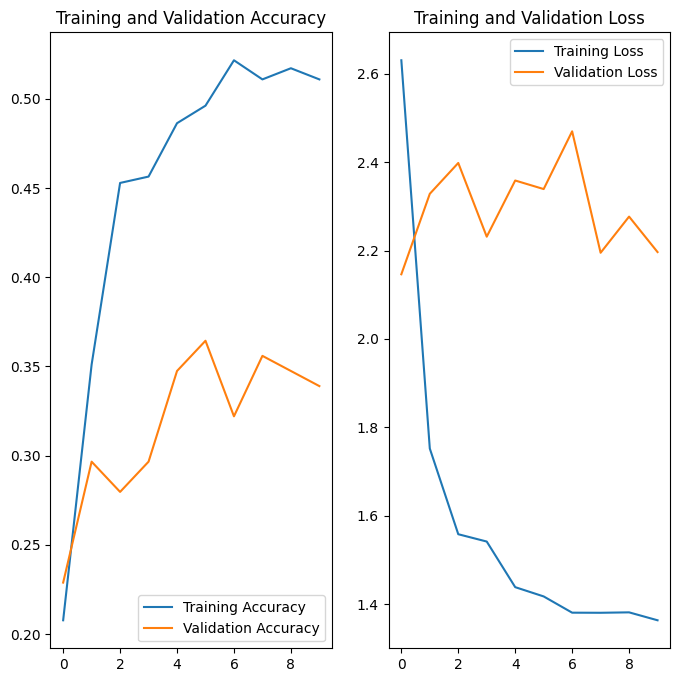

In [42]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

**CLASS DISTRIBUTION**

In [44]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/Upgrad/Dataset/Skin ca...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


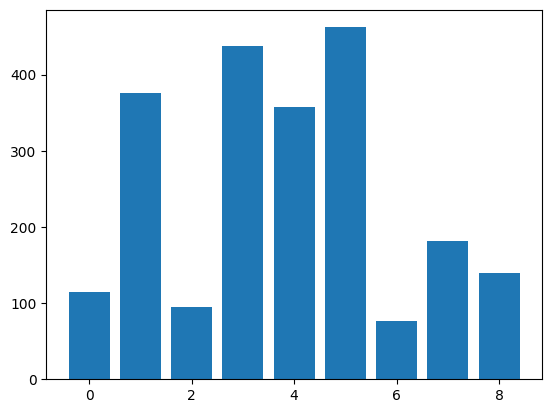

In [45]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Seborrheic keratosis has the least number of samples.

Pigmented benign keratosis has the highest number of samples

The classes 'basal cell carcinoma', 'melanoma', 'nevus', 'pigmented benign keratosis', dominate the data in terms proportionate number of samples.

In [46]:
#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

from sklearn.utils import class_weight
#Class=0, n=114 (5.092%)
#Class=1, n=376 (16.793%)
#Class=2, n=95 (4.243%)
#Class=3, n=438 (19.562%)
#Class=4, n=357 (15.945%)
#Class=5, n=462 (20.634%)
#Class=6, n=77 (3.439%)
#Class=7, n=181 (8.084%)
#Class=8, n=139 (6.208%)

class_weight = {0:5.09,
                1:16.79,
                2:4.24,
                3:19.56,
                4:15.94,
                5:20.63,
                6:3.43,
                7:8.08,
                8:6.20}

#class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight)


Epoch 1/20
56/56 [==============================] - 75s 1s/step - loss: 26.2302 - accuracy: 0.2494 - val_loss: 2.0401 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 65s 1s/step - loss: 21.0990 - accuracy: 0.3962 - val_loss: 1.6898 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 18.3680 - accuracy: 0.4648 - val_loss: 1.5692 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 65s 1s/step - loss: 17.3535 - accuracy: 0.5056 - val_loss: 1.6003 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 66s 1s/step - loss: 16.0312 - accuracy: 0.5352 - val_loss: 1.4891 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 65s 1s/step - loss: 15.1268 - accuracy: 0.5592 - val_loss: 1.4970 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 66s 1s/step - loss: 13.9632 - accuracy: 0.5792 - val_loss: 1.6745 - val_accuracy: 0.5257
Epoch 8/20
56

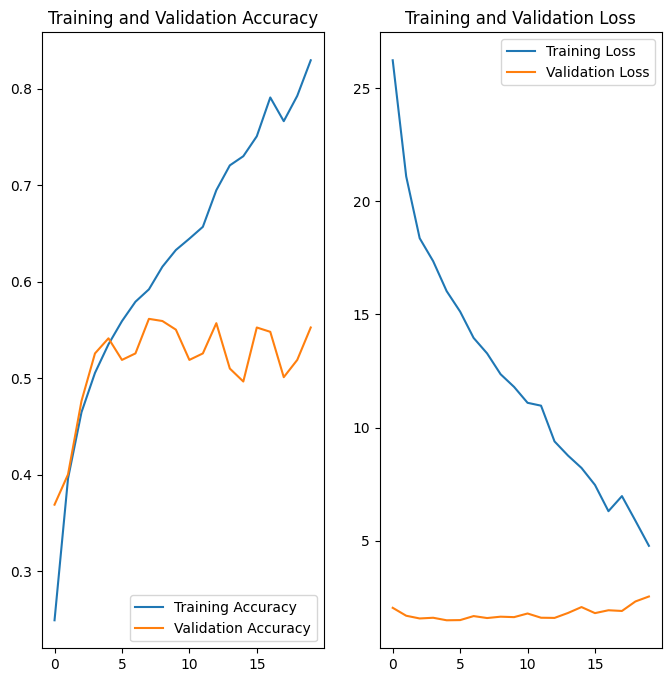

In [47]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [48]:
!pip install Augmentor

In [49]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath = '/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(150)
p.process()

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1DC9541ED0>: 100%|██████████| 150/150 [00:24<00:00,  6.10 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1DCF2F6DD0>: 100%|██████████| 2239/2239 [05:02<00:00,  7.40 Samples/s]


In [50]:
path_to_training_dataset="/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1DC6603E80>: 100%|██████████| 500/500 [00:36<00:00, 13.87 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1DC650C4C0>: 100%|██████████| 500/500 [00:30<00:00, 16.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C1DCF39F1C0>: 100%|██████████| 500/500 [00:25<00:00, 19.88 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C1DCF2F7370>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7C1DCAE51DE0>: 100%|██████████| 500/500 [01:38<00:00,  5.07 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1DC70B9B70>: 100%|██████████| 500/500 [00:25<00:00, 19.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C1DC70BBE80>: 100%|██████████| 500/500 [00:49<00:00, 10.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1DCF2F7370>: 100%|██████████| 500/500 [00:23<00:00, 20.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1DCF10C040>: 100%|██████████| 500/500 [00:24<00:00, 20.62 Samples/s]


In [51]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [52]:
import glob

In [53]:
path_list_new = glob.glob(os.path.join(data_dir_train, '*/*.jpg'))

In [54]:
path_list_new

['/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg',
 '/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg',
 '/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg',
 '/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg',
 '/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg',
 '/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025992.jpg',
 '/content/gdrive/MyDrive/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratos

In [55]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]

In [58]:
from glob import glob

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [61]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [63]:
new_df = pd.concat([original_df, df2], ignore_index=True)

In [64]:
new_df['Label'].value_counts()

Label
melanoma                      938
basal cell carcinoma          876
actinic keratosis             614
nevus                         596
dermatofibroma                595
pigmented benign keratosis    462
squamous cell carcinoma       181
vascular lesion               139
seborrheic keratosis           77
Name: count, dtype: int64

In [65]:
batch_size = 32
img_height = 180
img_width = 180

In [66]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9128 files belonging to 10 classes.
Using 7303 files for training.


In [67]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9128 files belonging to 10 classes.
Using 1825 files for validation.


In [75]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [81]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10)
])

In [82]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )

Epoch 1/20
229/229 [==============================] - 283s 1s/step - loss: 1.9827 - accuracy: 0.2822 - val_loss: 1.6616 - val_accuracy: 0.3704
Epoch 2/20
229/229 [==============================] - 263s 1s/step - loss: 1.6089 - accuracy: 0.3738 - val_loss: 1.6463 - val_accuracy: 0.3616
Epoch 3/20
229/229 [==============================] - 267s 1s/step - loss: 1.4875 - accuracy: 0.4204 - val_loss: 1.4111 - val_accuracy: 0.4433
Epoch 4/20
229/229 [==============================] - 268s 1s/step - loss: 1.3558 - accuracy: 0.4676 - val_loss: 1.4009 - val_accuracy: 0.4603
Epoch 5/20
229/229 [==============================] - 272s 1s/step - loss: 1.2233 - accuracy: 0.5242 - val_loss: 1.2995 - val_accuracy: 0.4871
Epoch 6/20
229/229 [==============================] - 287s 1s/step - loss: 1.0894 - accuracy: 0.5720 - val_loss: 1.3024 - val_accuracy: 0.4937
Epoch 7/20
229/229 [==============================] - 270s 1s/step - loss: 0.9835 - accuracy: 0.6110 - val_loss: 1.1894 - val_accuracy: 0.5518

In [4]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

***The CNN model which rectifies class imbalance using augmentor library is performing better than earlier models. The issue with overfitting is attended by this model. The Training accuracy and validation accuracy is almost same. The Training and validation loss is also inline***
